# User Authentication Exploration

#### I'm going to start out with a simple dataset and see what kind of insights I can glean from it. I want to display the power of exploratory data analysis and machine learning to show that we can transform even the simplest of datasets into something that's insightful, impactful, and valuable.
 
 - This dataset comes from the Los Alamos National Lab.
 - It contains data on user authentication events. 
 - Every time a user logs into their computer (and maybe applications as well) we collect the user, computer, and time of that event.
 - This dataset contains only those 3 fields.

This is data that large organizations have access to, but maybe don't use all that often. Let's see if we can see how valuable it may be.

In [192]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import bz2
import datetime
import calendar
import calmap
import matplotlib.dates as mdates
import random
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

The file is downloaded in as a .bz2.
It seems similar to a .zip file, as it is a compressed file.
We need to decompress and create a dataframe

In [1]:
#zipfile = bz2.BZ2File('lanl-auth-dataset-1-02.bz2') # open the file
#data = zipfile.read() # get the decompressed data
#newfilepath = 'lanl-auth-dataset-1-02-decompressed' # assuming the filepath ends with .bz2
#open(newfilepath, 'wb').write(data) # write a uncompressed file

In [3]:
#Create dataframe
#The file size is about 1.3GB
df = pd.read_csv('lanl-auth-dataset-1-02-decompressed', header = None, names=["Time", "User", "Computer"])

### Here is some additional information on the data, from the LANL site:
There are 11,362 users within the data set represented as U plus an anonymized, unique number, and 22,284 computers represented as C plus an anonymized, unique number. Timestamps, with a resolution of 1 second, start at an epoch 1 and all subsequent times are an offset from this epoch. The time frame of the actual data collection is not provided to enhance the anonymization of the data.

Some centralized computers (the Active Directory Servers) and the associated authentication events have been removed.

### My summary of the data:
- This data contains 30 days of user authentication events.
- The users and computer are anonymized.
- The timestamps are in Epoch time.
     - This is the time (in seconds) that have passed since 1/1/1970 (excluding leap seconds)
     - I will convert these to various forms of standard date formats since I would like to analyze time of day, day of the week, etc.

Lets take a look at the data:
Like I said earlier, I wanted to start with a simple dataset to see how much value there lies in such a simple dataset.

In [4]:
df.head()

,Time,User,Computer
0,4838401,U119,C9533
1,4838401,U119,C163
2,4838401,U2779,C3083
3,4838401,U1668,C6232
4,4838401,U4801,C4219


In [5]:
df.tail()

,Time,User,Computer
71540157,7257600,U7459,C8488
71540158,7257600,U385,C155
71540159,7257600,U13,C282
71540160,7257600,U112,C177
71540161,7257600,U112,C82


In [6]:
df.shape

(71540162, 3)

Unfortunately it appears that this is only 1 month of data. Luckily there are still 71,540,162 events, so plenty of data to try to analyze.

In [7]:
#Creating a new dataframe so I don't have to re-read the original file if anything goes wrong.
df_dates = df

In [8]:
#Create column for the date
df_dates['Date_time'] = pd.to_datetime(df_dates['Time'], unit = 's')

In [9]:
#Create column for the day of the week
df_dates['Day_Of_Week'] = pd.DatetimeIndex(df['Date_time']).dayofweek

In [10]:
#Create column for the hour of the day
df_dates['Hour'] = pd.DatetimeIndex(df['Date_time']).hour

In [11]:
df_dates.head()

,Time,User,Computer,Date_time,Day_Of_Week,Hour
0,4838401,U119,C9533,1970-02-26 00:00:01,3,0
1,4838401,U119,C163,1970-02-26 00:00:01,3,0
2,4838401,U2779,C3083,1970-02-26 00:00:01,3,0
3,4838401,U1668,C6232,1970-02-26 00:00:01,3,0
4,4838401,U4801,C4219,1970-02-26 00:00:01,3,0


In [12]:
print(df['Date_time'].min())
print(df['Date_time'].max())

1970-02-26 00:00:01
1970-03-26 00:00:00


##### We now have some more data to explore just by finding different ways to think about the Epoch time data.
- Let's look at the number of events by day of the week & by hour.
- This may give us an idea into what the normal business days/hours are for this organization

I don't want to make any assumptions so I want to verify how Day_Of_Week relates to the actual days of the week. After some Googling, I can confirm that Monday = 0, Tuesday = 1, so on and so forth

In [13]:
df_dates[df_dates['Day_Of_Week'] == 1]

,Time,User,Computer,Date_time,Day_Of_Week,Hour
15249049,5270400,U3569,C4031,1970-03-03 00:00:00,1,0
15249050,5270400,U3569,C239,1970-03-03 00:00:00,1,0
15249051,5270400,U2628,C2905,1970-03-03 00:00:00,1,0
15249052,5270400,U551,C684,1970-03-03 00:00:00,1,0
15249053,5270400,U5372,C6159,1970-03-03 00:00:00,1,0
...,...,...,...,...,...,...
70420239,7171199,U12,C598,1970-03-24 23:59:59,1,23
70420240,7171199,U12,C8631,1970-03-24 23:59:59,1,23
70420241,7171199,U4148,C132,1970-03-24 23:59:59,1,23
70420242,7171199,U4148,C115,1970-03-24 23:59:59,1,23


In [14]:
#Getting number of events per day of the week
dow_count_df = df_dates['Day_Of_Week'].groupby(df_dates['Day_Of_Week']).agg(dow_count = 'count').reset_index(drop=True)
#Creating column for day of the week
dow_count_df['Day_Of_Week'] = dow_count_df.index.values

In [15]:
dow_count_df

,dow_count,Day_Of_Week
0,8469556,0
1,7464631,1
2,5836658,2
3,12487748,3
4,11405686,4
5,13629830,5
6,12246053,6


In [16]:
max(dow_count_df['dow_count'])

13629830

The max number of events per day is 13,629,830 so let's divide by 1 million to make the numbers more digestible 

In [17]:
dow_count_df['dow_count_millions'] = dow_count_df['dow_count'] / 1000000

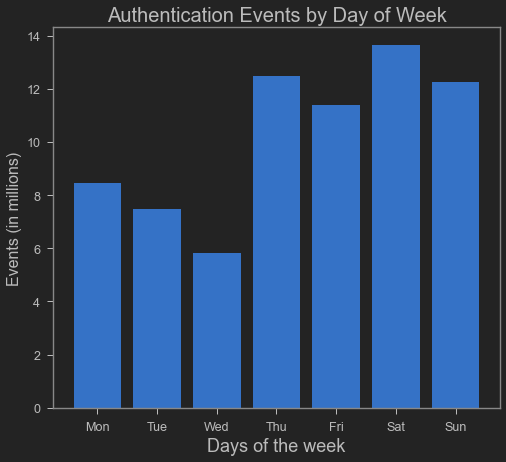

In [18]:
x = dow_count_df['Day_Of_Week']
y = dow_count_df['dow_count_millions']

#set limits (0,15) (millions)
y_ticks = np.arange(0, 15, 1)
# Change day of week number to text for x-axis label
plt.xticks(x, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.bar(x,y)
plt.title('Authentication Events by Day of Week', fontsize=20)
plt.xlabel('Days of the week', fontsize=18)
plt.ylabel('Events (in millions)', fontsize=16)
plt.show();

Interesting that there's more activity Thurs - Sun. Let's make sure that there are the same amount of full days for each day of the week

In [19]:
print(df_dates.sort_values(by='Date_time').head())

       Time  User Computer           Date_time  Day_Of_Week  Hour
0   4838401  U119    C9533 1970-02-26 00:00:01            3     0
13  4838401  U112      C82 1970-02-26 00:00:01            3     0
12  4838401  U112     C177 1970-02-26 00:00:01            3     0
11  4838401   U97     C161 1970-02-26 00:00:01            3     0
10  4838401  U159     C160 1970-02-26 00:00:01            3     0


In [20]:
print(df_dates.sort_values(by='Date_time').tail())

             Time   User Computer  Date_time  Day_Of_Week  Hour
71540160  7257600   U112     C177 1970-03-26            3     0
71540157  7257600  U7459    C8488 1970-03-26            3     0
71540158  7257600   U385     C155 1970-03-26            3     0
71540159  7257600    U13     C282 1970-03-26            3     0
71540161  7257600   U112      C82 1970-03-26            3     0


In [22]:
#getting the date from the datetime to track events per date
date_count_df = df_dates
date_count_df['Date'] = df_dates['Date_time'].dt.date

In [23]:
#Getting number of events per date
date_count_df = date_count_df['Date'].groupby(date_count_df['Date']).agg(date_count = 'count').reset_index()

In [24]:
#Let's look at the counts per date
date_count_df

,Date,date_count
0,1970-02-26,2825836
1,1970-02-27,3218591
2,1970-02-28,3441089
3,1970-03-01,3009860
4,1970-03-02,2753673
5,1970-03-03,2138210
6,1970-03-04,551518
7,1970-03-05,2705564
8,1970-03-06,3343773
9,1970-03-07,3361854


In [25]:
#Analyzing counts in millions
date_count_df['date_count'] = date_count_df['date_count'] / 1000000

Visualizing this to see if there is anything out of the ordinary or any dates that don't fall between the mix/max

In [26]:
date_index = np.array(pd.Series(pd.to_datetime(date_count_df['Date'])), dtype=pd.Series)
counts = np.array(pd.Series(date_count_df['date_count']), dtype=pd.Series)
daily_events = pd.Series(counts, index=date_index)

<AxesSubplot:>

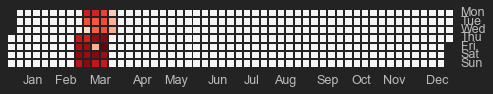

In [27]:
calmap.yearplot(daily_events)

It appears that all of the dates are in chronological order and there are no missing dates in-between. Now that we know there is nothing strange about the dates, let's take a look at the data differently

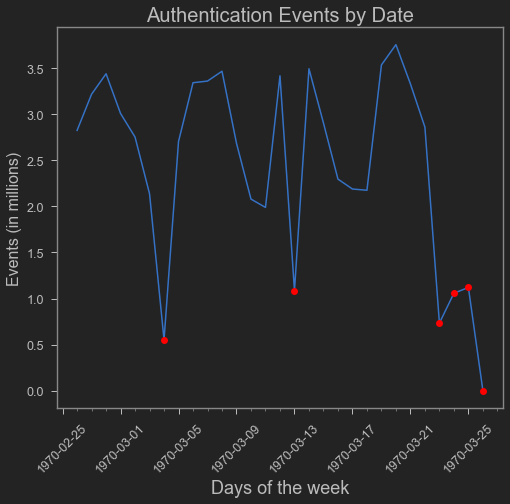

In [28]:
fig, ax = plt.subplots()
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)
#Emphasizing specific points
markers_on = [i for i, x in enumerate(counts) if x < 1.5]#[6,15,25,28]
plt.title('Authentication Events by Date', fontsize=20)
plt.xlabel('Days of the week', fontsize=18)
plt.ylabel('Events (in millions)', fontsize=16)
ax.plot_date(date_index, counts, '-', markevery=markers_on);
plt.plot(date_index,counts,markevery=markers_on, ls="", marker="o", label="points", color='red')

The points in red seem to be much lower than the rest of the points. Let's take a look at the distribution of daily events to see how we can use statistics to analyze this.

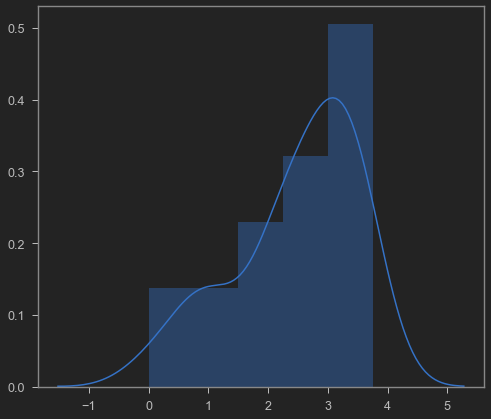

In [29]:
sns.distplot(counts);

We have a left-skewed distribution. That means that there is a long tail of days with a fewer amount of events, even if the mean, median, and mode are further to the right of the distribution.

###  Now that we have a better understanding of our data on a broad level, let's dive in a bit more and look as users & risk
Let's begin by looking at the following:
- Events by user
- Users who have used the most unique devices

Then we will look at the top users for both metrics and view their data over time

In [30]:
#Grouping by user and counting the number of authentication events
user_auth = df_dates['User'].groupby(df_dates['User']).agg(auth_count = 'count').reset_index()

In [31]:
#Finding the user with the most authentication events
user_auth[user_auth['auth_count'] == max(user_auth['auth_count'])]

,User,auth_count
518,U12,2664334


In [32]:
#Total number of unique users
user_auth['User'].count()

10071

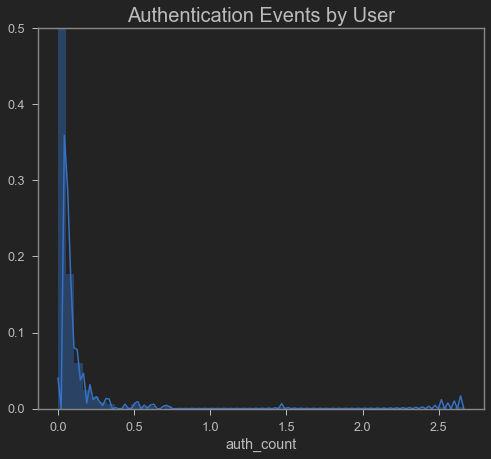

In [33]:
#Looking at the distribution of number of authentication events per user
fig, ax = plt.subplots()
plt.title('Authentication Events by User', fontsize=20)
ax.set_ylim(1,.5)
sns.distplot(user_auth['auth_count']/1000000, ax=ax)
plt.show()

Here we see a right-skewed distribution. This is simply the opposite of what we saw before with the daily events. Most users are on the lower end of the spectrum, with somewhere between 0-250,000 events. But there are users wth close to 1.5M and even over 2.5M events. That is why the graph appears to be stretched out to the right.
Let's see how many users have over 1,000,000 events

In [34]:
user_auth[user_auth['auth_count'] > 1000000]

,User,auth_count
518,U12,2664334
628,U13,2518033
3771,U4148,1465454


Only 3 users have over 1,000,000 events during this time. So that tail in the distribution above is caused, for the most part, by these 3 users. 

In [36]:
top_three_user_event_counts = user_auth['auth_count'][user_auth['auth_count'] > 1000000].sum()
total_events = df_dates.shape[0]
print("{:.2%}".format(top_three_user_event_counts / total_events))

9.29%


Close to 10% of authentication events during this time frame were from the same 3 users. Let's take a look at the events for these users over time

In [37]:
top_user_list = user_auth['User'][user_auth['auth_count'] > 1000000].tolist()
top_users_df = df_dates[df_dates['User'].isin(top_user_list)]

#Confirming that the number of events matches the sum of the top 3 users
top_users_df.shape

(6647821, 7)

In [38]:
#Grouping by user + date
top_user_daily_auth = top_users_df[['User', 'Date']].groupby(['User','Date']).size().reset_index()
#Renaming aggregate column
top_user_daily_auth.rename(columns={0:'user_daily_auth_count'}, inplace=True)

In [39]:
top_user_daily_auth

,User,Date,user_daily_auth_count
0,U12,1970-02-26,120051
1,U12,1970-02-27,121222
2,U12,1970-02-28,115129
3,U12,1970-03-01,104590
4,U12,1970-03-02,102635
...,...,...,...
80,U4148,1970-03-21,2798
81,U4148,1970-03-22,5754
82,U4148,1970-03-23,27
83,U4148,1970-03-24,146379


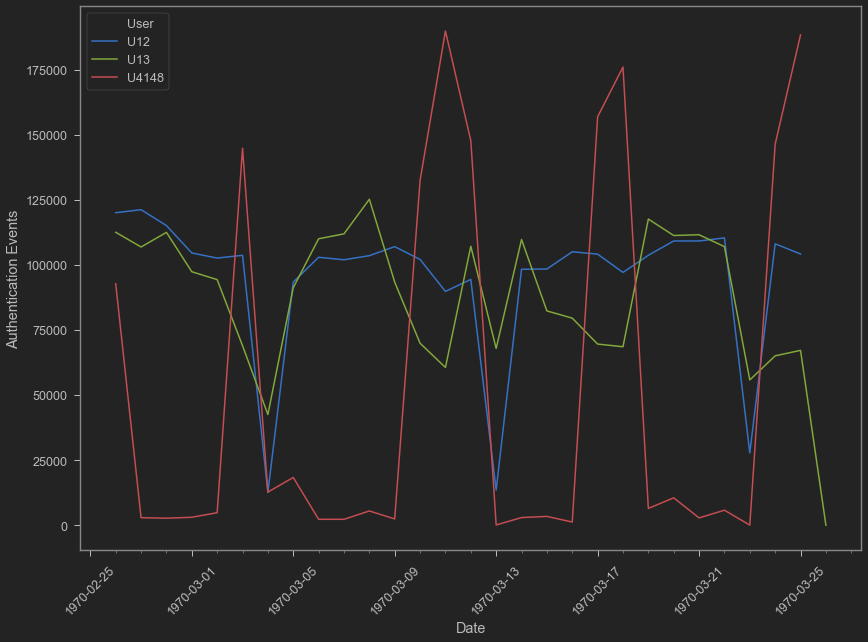

In [40]:
fig, ax = plt.subplots(figsize=(14,10))
sns.lineplot(x='Date',y='user_daily_auth_count', data=top_user_daily_auth, hue='User', ax=ax)
ax.set(xlabel='Date', ylabel='Authentication Events')
plt.xticks(rotation=45)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
plt.show()

Very interesting. The number of events per day seems to be very cyclical. 
It looks like users have had close to 200,000 authentication events in a single day. I'm not quite sure how that's possible. Maybe these could be a service account that needs to re-authenticate before running jobs. 
Let's take a look at some of the users around the median number of events per day. The reason why I don't want to use the mean is that the mean is not resistant to outliars. We saw the distribution of the number of events per user and these 3 users were extreme outliars. We can even take a look at the mean vs median before moving forward.

In [41]:
print('median: ', user_auth.median())
print('mean: ', user_auth.mean())

median:  auth_count    2412.0
dtype: float64
mean:  auth_count    7103.580776
dtype: float64


Exactly as expected. From the distribution graph we made earlier, we know that the vast majority of users had between 0 and 250,000 events. Let's take a random sample of 25 users within that range and see what their activity looks like. We will do exactly what we did for the top 3 users, just with a different sample of users. 


In [42]:
avg_user_list = user_auth['User'][(user_auth['auth_count'] > 0) & (user_auth['auth_count'] < 250000)].tolist()
avg_users_df = df_dates[df_dates['User'].isin(avg_user_list)]

avg_users_df.shape

(56954663, 7)

In [43]:
#Grouping by user + date
avg_user_daily_auth = avg_users_df[['User', 'Date']].groupby(['User','Date']).size().reset_index()
#Renaming aggregate column
avg_user_daily_auth.rename(columns={0:'user_daily_auth_count'}, inplace=True)

In [44]:
#Getting list of unique users & pulling random sample of 25 users
avg_user_list = random.choices(avg_user_daily_auth['User'].unique(), k=25)

#Filtering our dataframe for just the users in our sample
avg_users_df = avg_user_daily_auth[avg_user_daily_auth['User'].isin(avg_user_list)]


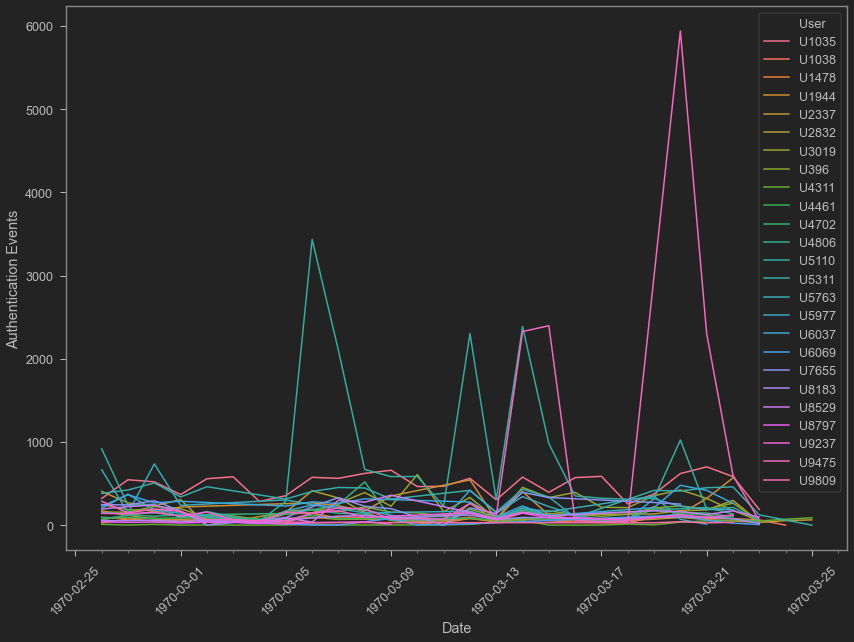

In [45]:
fig, ax = plt.subplots(figsize=(14,10))
sns.lineplot(x='Date',y='user_daily_auth_count', data=avg_users_df, hue='User', ax=ax)
ax.set(xlabel='Date', ylabel='Authentication Events')
plt.xticks(rotation=45)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
plt.show()

This looks as expected. We have a lot of users with a very consistent daily number of events between 0 and 500. There are a handful of users in this sample with more sporatic activity, but ~3000 events per day still comes nowhere near the 100,000+ we were seeing before. 

### Now we have an understanding of what the daily events for users looks like. Let's take a look at the relationship between users and computers now. 

In [46]:
df_dates.head()

,Time,User,Computer,Date_time,Day_Of_Week,Hour,Date
0,4838401,U119,C9533,1970-02-26 00:00:01,3,0,1970-02-26
1,4838401,U119,C163,1970-02-26 00:00:01,3,0,1970-02-26
2,4838401,U2779,C3083,1970-02-26 00:00:01,3,0,1970-02-26
3,4838401,U1668,C6232,1970-02-26 00:00:01,3,0,1970-02-26
4,4838401,U4801,C4219,1970-02-26 00:00:01,3,0,1970-02-26


In [47]:
#Looking for unique User/Computer combinations only
user_device_df = df_dates[['User', 'Computer']].drop_duplicates()

user_device_df = user_device_df.groupby(['User']).count().reset_index()

In [48]:
user_device_df

,User,Computer
0,U1,40
1,U10,17
2,U100,15
3,U1000,23
4,U10002,2
...,...,...
10066,U9992,11
10067,U9993,1
10068,U9997,1
10069,U9998,5


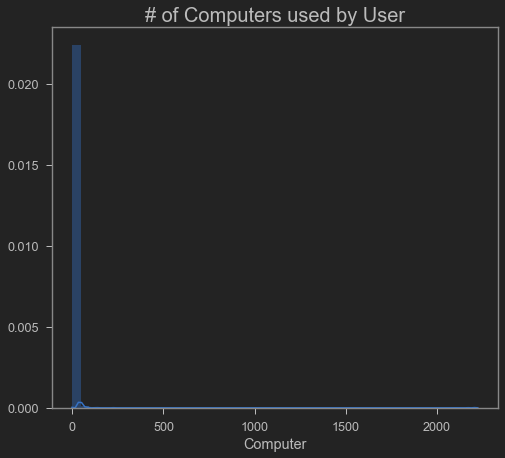

In [49]:
#Looking at the distribution of number of computers per user
fig, ax = plt.subplots()
plt.title('# of Computers used by User', fontsize=20)
sns.distplot(user_device_df['Computer'], ax=ax)
plt.show()

This is very similar to what we saw with daily events per user, a right skewed distribution. There are many users with a low number of computers used (< 100), but there are extreme outliars which is causing the skewedness. Let's take a look at this data in a different way.

{'whiskers': [<matplotlib.lines.Line2D at 0x1bfdd857d30>,
 'caps': [<matplotlib.lines.Line2D at 0x1bfdd865320>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bfdd857400>],
 'medians': [<matplotlib.lines.Line2D at 0x1bfdd8658d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bfdd865ba8>],
 'means': []}

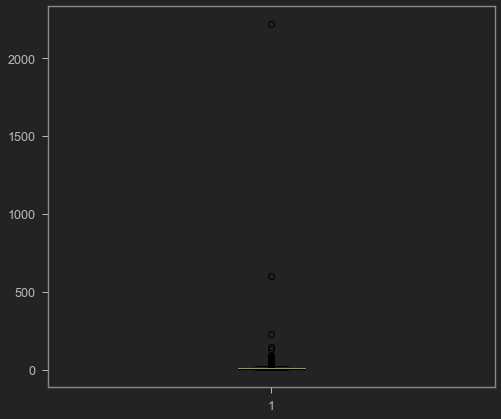

In [50]:
plt.boxplot(user_device_df['Computer'])

This was supposed to be a box and whisker chart. It looks like there are many outliars, but there is such an extreme outliar above 2000 computers that is causing these charts to have minimal value. 
We will check to see who this user is, out of curiosity, and then re-run these charts with different axes.

In [51]:
user_device_df[user_device_df['Computer'] > 2000]

,User,Computer
8086,U8060,2222


Part of me was expecting this to be one of our top 3 users by daily events. That would just be too easy and make too much sense.

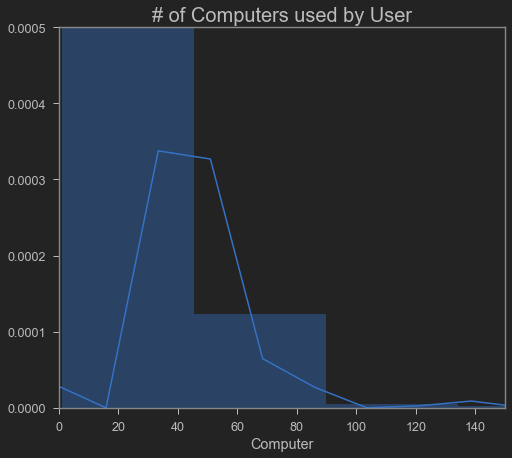

In [69]:
#Looking at the distribution of number of computers per user
fig, ax = plt.subplots()
#Adjusting axes
ax.set(ylim=(0, .0005))
ax.set(xlim=(0, 150))
plt.title('# of Computers used by User', fontsize=20)
sns.distplot(user_device_df['Computer'], ax=ax)
plt.show()

(0.0, 30.0)

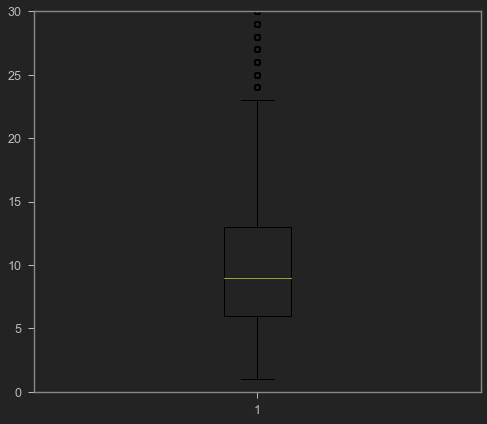

In [70]:
plt.boxplot(user_device_df['Computer'])
plt.ylim(0, 30)

Adjusting the axes definitely provided us with a better visual aid into the relationship between users and computers. 
The distribution chart and box and whisker plot both give similar insight into this metric

In [72]:
print('Q1: ', np.percentile(user_device_df['Computer'], 25))
print('Median: ', np.percentile(user_device_df['Computer'], 50))
print('Q3: ', np.percentile(user_device_df['Computer'], 75))

Q1:  6.0
Median:  9.0
Q3:  13.0


By getting the quartile and median data, we can now put actual numbers on our observations. The box represents 50% of all of our data. So 50% of users have used between 6 and 13 computers. 

# Okay now the fun can begin. 
#### Let's use machine learning to try and group the users into groups. We have to figure out which fields or which metrics would be most suitable to put into our model. 
We will have to use an unsupervised learning algorithm since we don't have an outcome field. For instance, if we had an indicator for whether the event was malicious or not, we could try to predict malicious activity for new events. Since we do not have a target feature, we will have to cluster similar users based on their characteristics, and then try to generalize each cluster.

With this dataset alone, all we can do is group the users and use the characteristics of each cluster to identifiy each group (high activity/high risk, low activity, high number of computers used, etc.)

I would try to dive into this and use a model to look at the data on an event level, however, I don't think the outcome would be very insightful. It would be another story if we were able to use a supervised learning technique and attempted to predict a certain characteristic of the event (e.g. whether the authentication event was malicious or not).

#### Ultimately the goal would be to identify both user groups and events and flag certain ones, depending on their characteristics.


Let's use number of computers & average events as our features

In [79]:
#We already have # of computers used per user
user_device_df.head()

,User,Computer
0,U1,40
1,U10,17
2,U100,15
3,U1000,23
4,U10002,2


We have the total number of events per user. Now we just need to divide by the number of days

In [84]:
#Remember that last day only had 5 events since I only used one file out of the 9 files from the original dataset.
#Removing 1 day from the # of total dates in the dataset
total_days = df_dates['Date'].nunique() - 1 
user_auth['avg_daily_events'] = user_auth['auth_count'] / total_days


In [85]:
user_auth.head()

,User,auth_count,avg_daily_events
0,U1,93824,3350.857143
1,U10,27013,964.750000
2,U100,16138,576.357143
3,U1000,28036,1001.285714
4,U10002,4,0.142857


In [86]:
#Confirming that we have the same number of users for each metric
print(user_device_df.shape)
print(user_auth.shape)

(10071, 2)
(10071, 3)


In [327]:
user_metrics_df = user_device_df.merge(user_auth, on = 'User')

In [328]:
user_metrics_df = user_metrics_df[['User', 'Computer', 'avg_daily_events']]

In [329]:
#Let's make better column names
user_metrics_df.columns = ['user', 'n_computers_used', 'avg_daily_events']

In [330]:
user_metrics_df

,user,n_computers_used,avg_daily_events
0,U1,40,3350.857143
1,U10,17,964.750000
2,U100,15,576.357143
3,U1000,23,1001.285714
4,U10002,2,0.142857
...,...,...,...
10066,U9992,11,114.428571
10067,U9993,1,0.428571
10068,U9997,1,0.571429
10069,U9998,5,27.392857


In [331]:
#Let's see if there is any correlation between computers used and average daily events
user_metrics_df.corr()

,n_computers_used,avg_daily_events
n_computers_used,1.000000,0.072857
avg_daily_events,0.072857,1.000000


Being closer to 1 or -1 would  indicate that there is a strong correlation. Since these features are 0.07 they are nowhere near correlated. 
This is a good thing. In a larger dataset, if the two variables were strongly correlated, it may not be in our best interest to include them both in the model since it would almost be redudant and add to much weight to those fields.

# K-means
We're going to use k-means as our model of choice. 

Imagine we were plotting the users as points on a graph based on their features. This model begins by placing points on the grid, known as centroids. As we add our data points, they are assigned to the closest centroid. As new points continue to be added, the centroid moves around to maintain it's position in the center of it's points. The points around each centroid eventually become a cluster.

All we need to do is figure out how many clusters we should use when assigning new points.
<br></br>

We're going to have to scale & normalize our data first. What's going to happen is that the outliers are most likely each going to become it's own cluster since they stray very far from the other points. 
*Think about it this way...*
If we were going to try and put a model together that predicts apartment rent prices by # of rooms and square footage, a change in 1 bedroom would change the rent price drastically, while changing the square footage by 1 will certainly not affect the price at all. Scaling our data  allows our model to treat each feature similarly and not over-value a feature if we don't deem it necessary.
> Any algorithm where distance plays a vital role for prediction or classification should have normalized features.

We will also have to remove outliars. K-means is very sensitive to outliers, since it uses distances between points to identify clusters.
We will look at the z scores for both of our features. A z-score between -3 and 3 means that the data falls within 3 standard deviations of the mean. 99% of the data falls within this range (in a normal distribution). By removing data points with a z-score absolute value greater than 3, we are removing the "1%" of our data that strays very far away from our average.

In [332]:
#Creating z-score for avg_events
user_metrics_df['avg_events_z'] = np.abs(stats.zscore(user_metrics_df['avg_daily_events']))
#Creating z-score for n_computers
user_metrics_df['n_computers_z'] = np.abs(stats.zscore(user_metrics_df['n_computers_used']))
#removing rows where the absolute value of the avg_events z-score is greater than 3
user_metrics_df = user_metrics_df[(user_metrics_df['avg_events_z'] < 3) & (user_metrics_df['n_computers_z'] < 3)]
#removing the columns with the z scores since we don't need them anymore
user_metrics_df.drop(['avg_events_z', 'n_computers_z'], axis=1, inplace=True)
#Saving a labeled version of df
labeled_user_df = user_metrics_df
#Dropping the user ID since the model won't know how to handle a string
user_metrics_df_anonymized = user_metrics_df.drop('user', axis=1)

C:\Users\M\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [333]:
labeled_user_df

,user,n_computers_used,avg_daily_events
0,U1,40,3350.857143
1,U10,17,964.750000
2,U100,15,576.357143
3,U1000,23,1001.285714
4,U10002,2,0.142857
...,...,...,...
10066,U9992,11,114.428571
10067,U9993,1,0.428571
10068,U9997,1,0.571429
10069,U9998,5,27.392857


#### For the sake of adding a security context to this analysis, by performing the z score outlier filter, we have identified users with anomalous activity. With more data, we could perform a more in-depth analysis of their activity.

In [334]:
#Normalizing data
scaler = MinMaxScaler()
normalized_user_data = pd.DataFrame(scaler.fit_transform(user_metrics_df_anonymized), \
                               index=user_metrics_df_anonymized.index, \
                               columns=user_metrics_df_anonymized.columns)

C:\Users\M\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [335]:
normalized_user_data.head()

,n_computers_used,avg_daily_events
0,0.506494,0.654074
1,0.207792,0.188310
2,0.181818,0.112497
3,0.285714,0.195442
4,0.012987,0.000021


Now we need to figure out how many clusters to use. For this, we will use WCSS - *within-cluster sum of squares*. 
Basically, this measures the variability. The smaller the number, the more condensed the cluster is. Obviously, we want condensed clusters, but at a certain point we will be overfitting our data.

Let's say we have 10 data points and want to cluser them together. Obviously we could use 10 clusters and each point would be it's own group. But that wouldn't be very insightful to have each user in it's own cluster. We need to find the right balance between having meaningful, condensed clusters & not over-fitting our data.

From my research, we will plot the WCSS and follow the "elbow" rule. We will choose the number of clusters where the line begins to bend drastically.

In [336]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 39)
    kmeans.fit(user_metrics_df_anonymized)
    wcss.append(kmeans.inertia_)

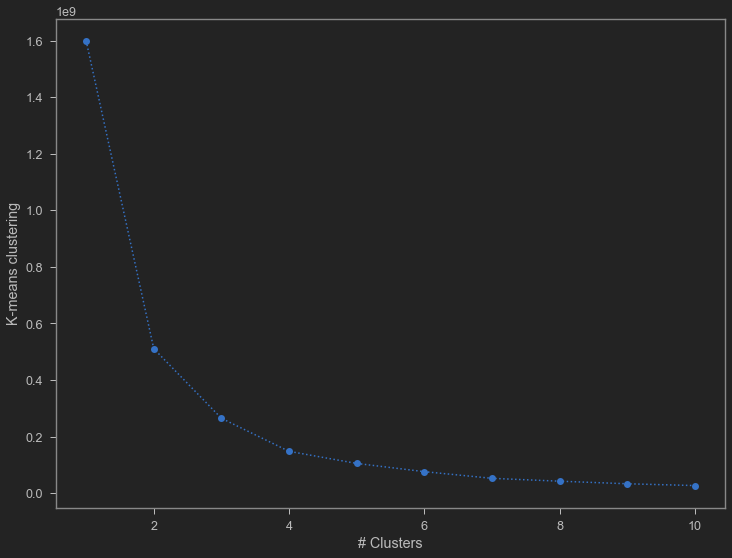

In [337]:
plt.figure(figsize = (12,9))
plt.plot(range(1,11), wcss, marker = 'o', ls=':')
plt.xlabel('# Clusters')
plt.ylabel('K-means clustering')
plt.show();

It looks like 3 or 4 will be our number of clusters. We will start with 4.
Let's plot the points so we can look at the before/after.

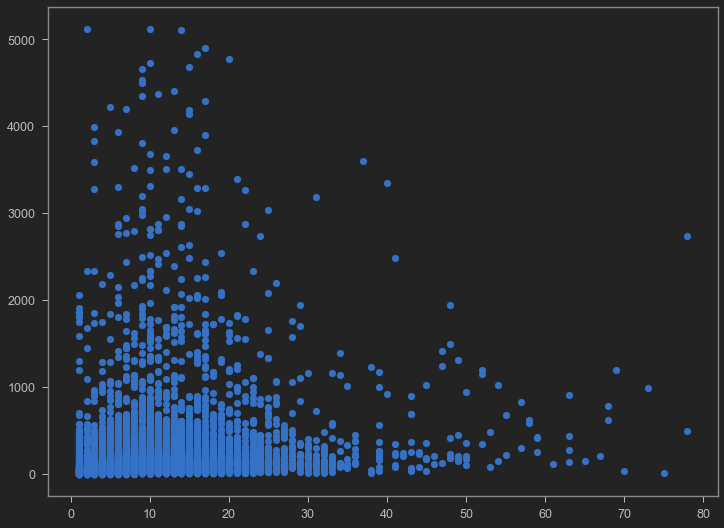

In [338]:
plt.figure(figsize = (12,9))
plt.scatter(user_metrics_df_anonymized['n_computers_used'], user_metrics_df_anonymized['avg_daily_events'])

In [364]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 39)
kmeans.fit(normalized_user_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=39, tol=0.0001, verbose=0)

In [365]:
user_kmeans_df = labeled_user_df.copy()
user_kmeans_df['kmeans_cluster'] = kmeans.labels_

In [366]:
user_kmeans_analysis_df = user_kmeans_df.groupby(['kmeans_cluster']).mean()

In [367]:
user_kmeans_analysis_df

,n_computers_used,avg_daily_events
kmeans_cluster,,
0,16.273403,187.718365
1,6.509360,103.335193
2,12.359307,2314.961503
3,39.896040,355.338755


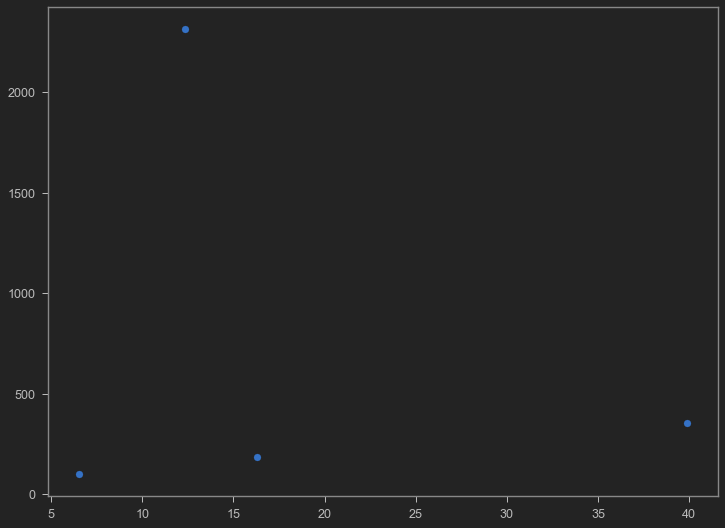

In [368]:
plt.figure(figsize = (12,9))
plt.scatter(user_kmeans_analysis_df['n_computers_used'], user_kmeans_analysis_df['avg_daily_events'])

#### With the data we fed into the model, we can generalize our clusters fairly easily.
 - Low computers used, low event frequency
 - High event frequency
 - Moderate number of computers used and moderate number of events
 - Large number of unique computers used

In [369]:
user_kmeans_analysis_df.rename({0:'Moderate/Moderate',
                        1:'Low/Low',
                        2:'High event freq',
                        3:'Large n computers'})

,n_computers_used,avg_daily_events
kmeans_cluster,,
Moderate/Moderate,16.273403,187.718365
Low/Low,6.509360,103.335193
High event freq,12.359307,2314.961503
Large n computers,39.896040,355.338755


In [370]:
user_kmeans_df['Label'] = user_kmeans_df['kmeans_cluster'].map({0:'Moderate/Moderate',
                        1:'Low/Low',
                        2:'High event freq',
                        3:'Large n computers'})

In [371]:
user_kmeans_df

,user,n_computers_used,avg_daily_events,kmeans_cluster,Label
0,U1,40,3350.857143,2,High event freq
1,U10,17,964.750000,0,Moderate/Moderate
2,U100,15,576.357143,0,Moderate/Moderate
3,U1000,23,1001.285714,0,Moderate/Moderate
4,U10002,2,0.142857,1,Low/Low
...,...,...,...,...,...
10066,U9992,11,114.428571,1,Low/Low
10067,U9993,1,0.428571,1,Low/Low
10068,U9997,1,0.571429,1,Low/Low
10069,U9998,5,27.392857,1,Low/Low


<AxesSubplot:xlabel='n_computers_used', ylabel='avg_daily_events'>

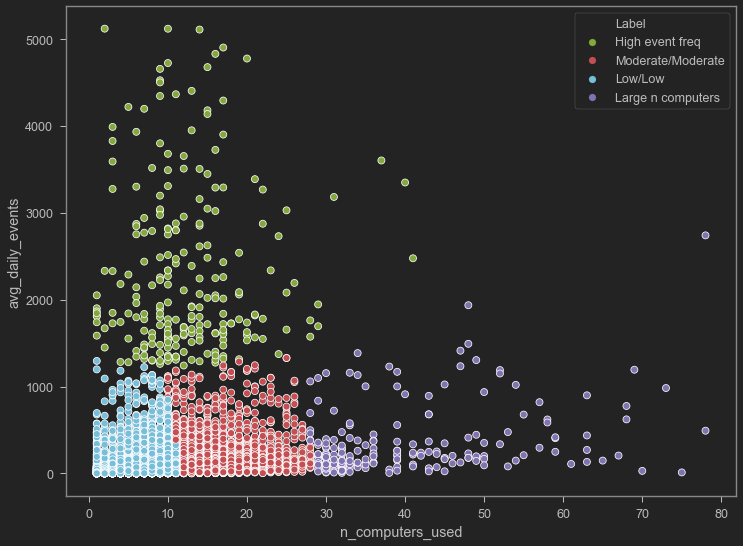

In [372]:
x_axis = user_kmeans_df['n_computers_used']
y_axis = user_kmeans_df['avg_daily_events']
plt.figure(figsize=(12,9))
sns.scatterplot(x_axis,y_axis, hue=user_kmeans_df['Label'], palette = ['g', 'r', 'c', 'm'])

##### 3 clusters may actually be more appropriate. It looks like the light blue/red really have no differentiating factors. But this change would be as simple as changing the number of clusters from 4 to 3,  above.

Now we have clustered users with similar characteristics together. Security teams could use these insights to bucket their users into certain risk groups. Not only that, but they can also use this as a baseline to detect anomalous behaviors in the future.

### The purpose of this project was to show how, event with a small amount of features, we can still extract some pretty cool and powerful insights from the data. 

We only started with 3 attributes: time, user, computer. We were able to put a really comprehensive analysis together. We were able to identify common characteristics in users and assign them to their own group. 

We identified user outliars so we could monitor them better. Since we grouped the users together by characteristics, we could set up an automated alert when somebody moves into another cluster.

There is so much that can be done with data. All mature security teams have data that would be extremely valuable, if explored. However, many of these teams perform an extremely shallow anylsis, at best. These teams collect so much data just from day-to-day operations; It's unfortunate that they sit on a gold mine of information but continue to take a reactive stance, rather than a predictive/proactive mentality. 
